# Test Data Analysis
Just messin around

In [1]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1


E0000 00:00:1761102504.545558 3138075 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1', 'email': 'Alexxander1611@gmail.com'}


In [ ]:
# Fetch IMU data

import pandas as pd

imu_coll = db.collection('UserIMU').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data.items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Alpha ,gyro,1.760924e+09,0,5.000000,5.853659,-2.164634,1.760924e+09
1,Alpha ,gyro,1.760924e+09,0,4.603659,4.817073,-1.463415,1.760924e+09
2,Alpha ,gyro,1.760924e+09,0,4.420732,2.225610,-1.189024,1.760924e+09
3,Alpha ,gyro,1.760924e+09,0,5.182927,3.079268,-1.737805,1.760924e+09
4,Alpha ,gyro,1.760924e+09,0,4.054878,3.018293,-2.378049,1.760924e+09
...,...,...,...,...,...,...,...,...
653,Alpha ,planar,1.760924e+09,0,-0.079009,-0.004788,9.907207,1.760924e+09
654,Alpha ,planar,1.760924e+09,0,-0.110133,-0.050278,9.880871,1.760924e+09
655,Alpha ,planar,1.760924e+09,0,-0.112527,-0.021548,9.823410,1.760924e+09
656,Alpha ,planar,1.760924e+09,0,-0.160412,-0.074220,9.916783,1.760924e+09


In [5]:
# Visualize IMU data of a given type

devname = "Alpha\x00"
imutype = "gyro"

dev = df[df['Type'] == imutype].copy()
dev = dev[dev['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
0,Alpha ,gyro,1.760924e+09,0,5.000000,5.853659,-2.164634,1.760924e+09,0.000000
1,Alpha ,gyro,1.760924e+09,0,4.603659,4.817073,-1.463415,1.760924e+09,0.119406
2,Alpha ,gyro,1.760924e+09,0,4.420732,2.225610,-1.189024,1.760924e+09,0.182724
3,Alpha ,gyro,1.760924e+09,0,5.182927,3.079268,-1.737805,1.760924e+09,0.359075
4,Alpha ,gyro,1.760924e+09,0,4.054878,3.018293,-2.378049,1.760924e+09,0.419493


/Users/callum/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


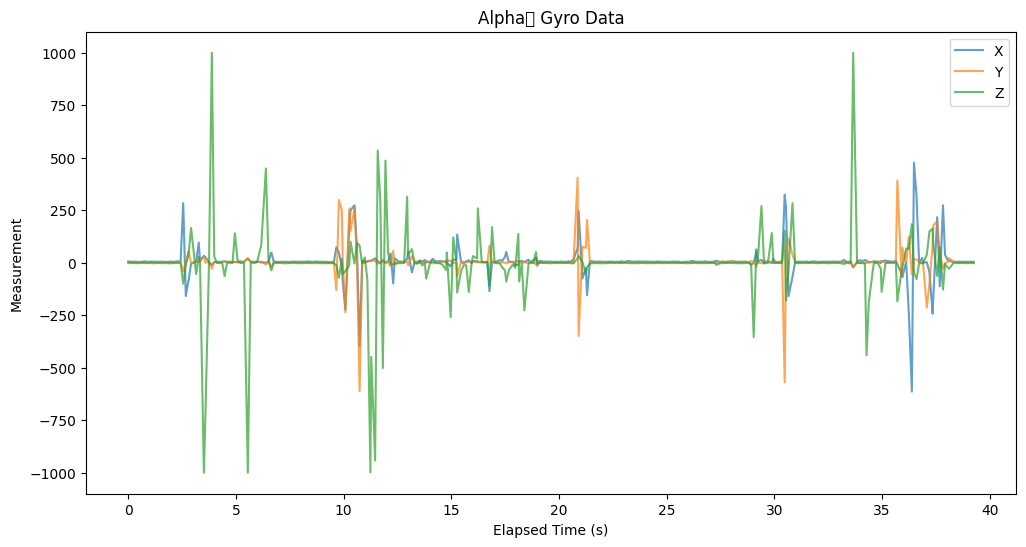

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' ' + (imutype[0].upper() + imutype[1:]) + ' Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement')
plt.legend()
plt.show()

## Collective Data

In [23]:

# Fetch collective data

import pandas as pd

imu_coll = db.collection('UserData').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data['_imu'].items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Alpha ,gyro,1.761102e+09,0,0.0,0.0,0.0,1.761102e+09
1,Alpha ,gyro,1.761102e+09,0,0.0,0.0,0.0,1.761102e+09
2,Alpha ,gyro,1.761102e+09,0,0.0,0.0,0.0,1.761102e+09
3,Alpha ,gyro,1.761102e+09,0,0.0,0.0,0.0,1.761102e+09
4,Alpha ,gyro,1.761102e+09,0,0.0,0.0,0.0,1.761102e+09


In [26]:
# Visualize IMU data of a given type

devname = "Alpha\x00"
imutype = "planar"

dev = df[df['Type'] == imutype].copy()
dev = dev[dev['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
320,Alpha ,planar,1.761102e+09,0,0.055067,-0.016759,9.873688,1.761102e+09,0.000000
321,Alpha ,planar,1.761102e+09,0,0.067038,0.011971,9.943120,1.761102e+09,0.015384
322,Alpha ,planar,1.761102e+09,0,-0.021548,-0.057461,9.900024,1.761102e+09,0.030769
323,Alpha ,planar,1.761102e+09,0,0.122104,-0.055067,9.835381,1.761102e+09,0.046154
324,Alpha ,planar,1.761102e+09,0,0.067038,-0.074220,9.849746,1.761102e+09,0.061538


/Users/callum/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


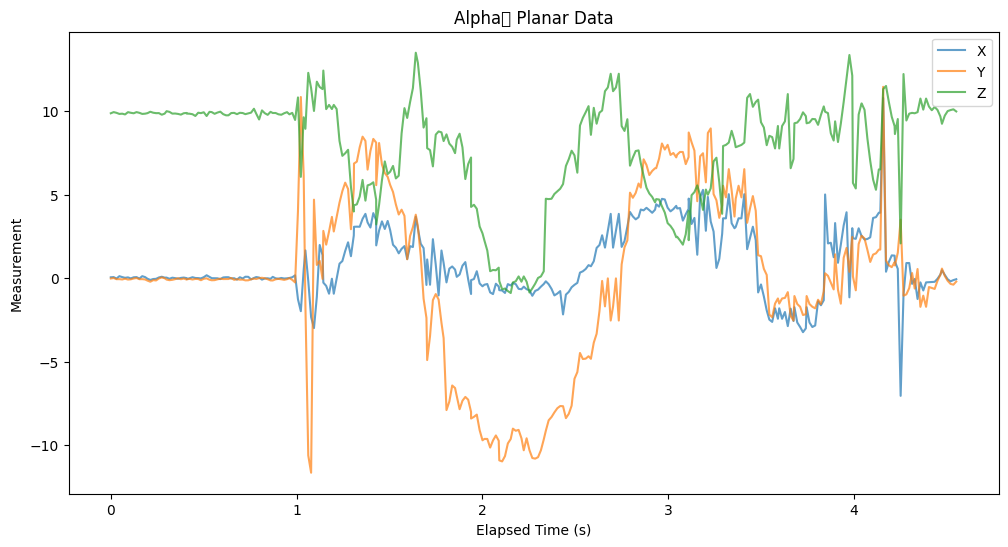

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' ' + (imutype[0].upper() + imutype[1:]) + ' Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie